# Лабораторная работа #3 Sklearn и основы ML Часть 2

## Инструменты и ресурсы для выполнения задания

### Библиотеки Python

  * [Sklearn](http://scikit-learn.org/stable/)
    - [Video tutorials](https://www.youtube.com/playlist?list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A)
    - [A Gentle Introduction to Scikit-Learn](http://machinelearningmastery.com/a-gentle-introduction-to-scikit-learn-a-python-machine-learning-library/)
  
### Ресурсы по ML
  * [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
  
## Задания
  
  1. Для моделей, обученных в предыдущей части постройте ROC и посчтатйте метрику ROC AUC. 
  2. Верно ли, что классификаторы из предыдущей части действуют путем сравнения некоторой оценки принадлежности положительному классу с некоторым порогом?
  3. Какой классификатор имеет ROC AUC близкий к 0?
  4. На данный момент параметры алгоритмов KNN и Decision Tree выбраны наугад. Для одбора параметров используется т.н. Gree Search (sklearn имеет соответствующий модуль). 
    * Найдите оптимальный набор параметров дерева, перебрав значения параметров по сетке. Параметры для настройки: критерий разбиения, максимальная глубина, число признаков для каждого узла, минимальное число объектов в листе.
    * Найдите оптимальный набор параметров для KNN, перебрав значения параметров по сетке. Параметры для настройки: число соседей, функция расстояния, схема взвешивания.
  

In [6]:
import requests
import pandas as pd
from sklearn.utils import shuffle

SPAM_NAMES_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAM_DATA_URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

spam_data = pd.read_csv(SPAM_DATA_URL)
names = requests.get(SPAM_NAMES_URL).text.split()[-57 * 2:] # n_features = 57
feature_names = [n.strip(':') for n in names[::2]]
feature_names += ['spam']
spam_data.columns = feature_names # set feature names

spam_data = shuffle(spam_data)
X = spam_data[spam_data.columns[:-1]]
y = spam_data[spam_data.columns[-1]]

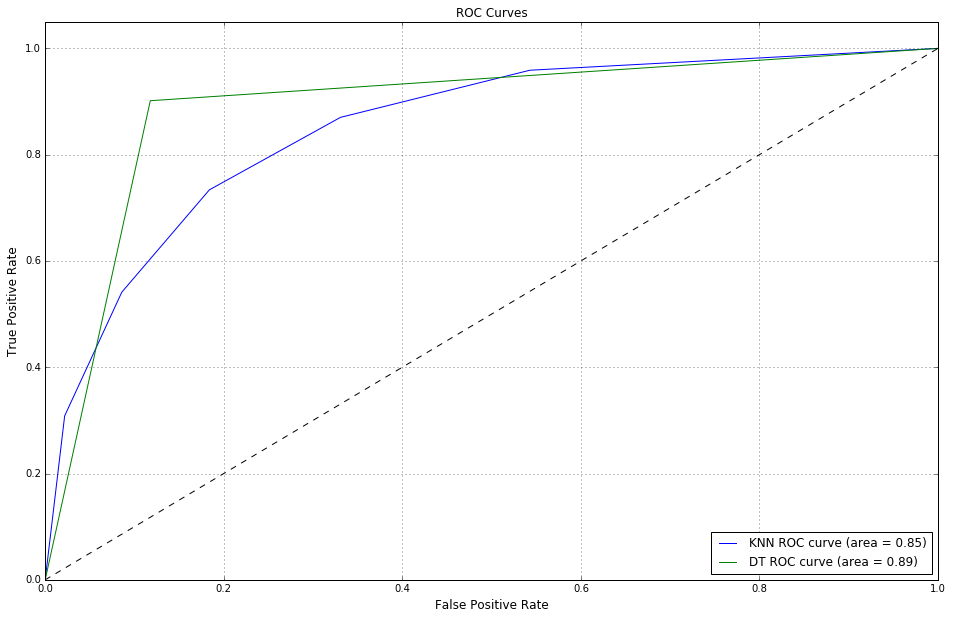

In [11]:
# ROC curves

% matplotlib inline
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_score = knn.predict_proba(X_test)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_y_score = dt.predict_proba(X_test)

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_score[:, 1]) # take probability estimates of the positive class
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_score[:, 1])
knn_roc_auc = auc(knn_fpr, knn_tpr)
dt_roc_auc = auc(dt_fpr, dt_tpr)
plt.figure(figsize=(16, 10))
plt.plot(knn_fpr, knn_tpr, label='KNN ROC curve (area = {:.2f})'.format(knn_roc_auc))
plt.plot(dt_fpr, dt_tpr, label='DT ROC curve (area = {:.2f})'.format(dt_roc_auc), color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize='large')
plt.ylabel('True Positive Rate', fontsize='large')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [12]:
# Верно ли, что классификаторы из предыдущей части действуют путем сравнения некоторой оценки принадлежности
# положительному классу с некоторым порогом?

# KNN - да, сравнивает оценку принадлежности классу с порогом
# DT - нет, сразу определяет класс по порогу без промежуточной оценки

In [13]:
# Какой классификатор имеет ROC AUC близкий к 0?

# Из этих двух - никакой.

In [21]:
# KNN with params tuned

from sklearn.preprocessing import Normalizer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

knn_param_grid = {'n_neighbors': [3, 5, 7, 9],
       'weights': ['uniform', 'distance'],
       'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
       }

print('Tuning hyper-parameters for accuracy\n')
clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_param_grid, cv=5, scoring='accuracy')
normalizer = Normalizer().fit(X_train)
clf.fit(normalizer.transform(X_train), y_train)

print('Best parameters set found on development set:\n')
for k, _ in knn_param_grid.items():
    print("'{}': {}".format(k, clf.best_params_.get(k)))
print()
print('Best accuracy score:')
print('{:.3f}'.format(clf.best_score_))
print()
print('Grid scores on development set:\n')
for params, mean_score, scores in clf.grid_scores_:
    print('{:.3f} for {}'.format(mean_score, params))
print()
print('Detailed classification report:\n')
print('The model is trained on the full development set.')
print('The scores are computed on the full evaluation set.\n')
y_true, y_pred = y_test, clf.predict(normalizer.transform(X_test))
print(classification_report(y_true, y_pred))

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

'n_neighbors': 3
'weights': distance
'algorithm': auto

Best accuracy score:
0.827

Grid scores on development set:

0.821 for {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'auto'}
0.827 for {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'auto'}
0.809 for {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'auto'}
0.821 for {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto'}
0.799 for {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto'}
0.817 for {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'auto'}
0.794 for {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto'}
0.813 for {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'auto'}
0.821 for {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree'}
0.827 for {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'ball_tree'}
0.809 for {'n_neighbors': 5, 'weights': 'uniform', 'algorithm':

In [18]:
# DT with params tuned

dt_param_grid = {'splitter': ['best', 'random'],
    'max_depth': [None, 2**30, 2**28],
    'max_features' : [None, 'auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    }

print('Tuning hyper-parameters for accuracy\n')
clf = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dt_param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print('Best parameters set found on development set:\n')
for k, _ in dt_param_grid.items():
    print("'{}': {}".format(k, clf.best_params_.get(k)))
print()
print('Best accuracy score:')
print('{:.3f}'.format(clf.best_score_))
print()
print('Grid scores on development set:\n')
for params, mean_score, scores in clf.grid_scores_:
    print('{:.3f} for {}'.format(mean_score, params))
print()
print('Detailed classification report:\n')
print('The model is trained on the full development set.')
print('The scores are computed on the full evaluation set.\n')
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Tuning hyper-parameters for accuracy

Best parameters set found on development set:

'min_samples_leaf': 4
'max_features': None
'max_depth': 268435456
'splitter': best

Best accuracy score:
0.902

Grid scores on development set:

0.895 for {'min_samples_leaf': 1, 'splitter': 'best', 'max_depth': None, 'max_features': None}
0.883 for {'min_samples_leaf': 1, 'splitter': 'random', 'max_depth': None, 'max_features': None}
0.897 for {'min_samples_leaf': 2, 'splitter': 'best', 'max_depth': None, 'max_features': None}
0.888 for {'min_samples_leaf': 2, 'splitter': 'random', 'max_depth': None, 'max_features': None}
0.900 for {'min_samples_leaf': 3, 'splitter': 'best', 'max_depth': None, 'max_features': None}
0.881 for {'min_samples_leaf': 3, 'splitter': 'random', 'max_depth': None, 'max_features': None}
0.899 for {'min_samples_leaf': 4, 'splitter': 'best', 'max_depth': None, 'max_features': None}
0.883 for {'min_samples_leaf': 4, 'splitter': 'random', 'max_depth': None, 'max_features': None}
0.